In [319]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
import scipy.signal
import scipy.cluster.vq as vq
import scipy.io.wavfile as wav
import python_speech_features as speech
from sklearn import mixture
from sklearn.mixture import GaussianMixture as gmm
import scipy.spatial.distance as dist
import math

In [320]:
def BIC(k, Sigs, Koefs, Lengths, penalty):
    P1 = Lengths[Koefs[k][0]]* np.log(np.abs(np.cov(Sigs[Koefs[k][0]])+0.0001))
    P2 = Lengths[Koefs[k][1]] * np.log(np.abs(np.cov(Sigs[Koefs[k][1]])+0.0001))
    P3 = (Lengths[Koefs[k][0]]+Lengths[Koefs[k][1]])*np.log(np.abs(np.linalg.det(np.cov(Sigs[Koefs[k][0]], Sigs[Koefs[k][1]]))+0.0001))
    bic= 0.5*P1 + 0.5*P2-0.5*P3  + penalty*(2.5*(Lengths[Koefs[k][0]]+Lengths[Koefs[k][1]]))
    return bic

In [321]:
def fit_samples(samples, num):
	gmix = mixture.GaussianMixture(n_components=num, covariance_type='full')
	gmix.fit(samples)
	return (gmix.means_)

#glavna funkcija:
def calculate(Means, Mfccs, Sigs, Lengths, Freqs, M, num, penalty):
    N = min(num, 25)
    
    global ind
    
    Koefs = []
    for i in range(0, N):
        Koefs.append([0,0])
    
    MaxVals = np.zeros((N))
    
    #racunanje N najblizih koeficijenata
    for i in range(0,num-1):
        for j in range(2,num):
            if(j>i):
                
                for l in range(0,N):
                    if(M[i][j]>=MaxVals[l]):
                        for k in range(N, l+1):
                            MaxVals[k]=MaxVals[k-1]
                            Koefs[k] = Koefs[k-1]
                        MaxVals[l] = M[i][j]
                        Koefs[l] = [i,j]
                        break
        
    #racunanje najveceg BIC
    Bics = []
        
    for i in range(0, N):
        if(Koefs[i] == [0,0]):
            N = N-1
            continue
        Bics.append(BIC(i, Sigs, Koefs, Lengths, penalty))
    
    if(len(Bics)<=1):
        ind =-1
        return
        
    max_bic = Bics[0]
    max_i=0
    for i in range(1,N):
        if(Bics[i]>max_bic):
            max_bic = Bics[i]
            max_i = i
        
    Means_new = []
    Mfccs_new = []
    Sigs_new = []
    Lengths_new = []
    Freqs_new = []
    M_new = np.zeros((num, num))
    
    if(max_bic<0):
        return (Means_new, Mfccs_new, Sigs, Lengths_new, Freqs_new, M_new, -1)
    
    [i,j] = Koefs[max_i]
    spoji_klastere(i, j)
    sig_new = 0.5*Sigs[i]+0.5*Sigs[j]
    means_new = 0.5*Means[i]+0.5*Means[j]
    
    for k in range (0,num):
        if(k!=i and k!=j):
            Sigs_new.append(Sigs[k])
            Mfccs_new.append(Mfccs[k])
            Means_new.append(Means[k])
            Lengths_new.append(Mfccs[k].shape[0])
            Freqs_new.append(Freqs[k])
    
    for k in range(0, num-1):
        if(k<i):
            for l in range(0, num-1):
                if(l<i):
                    M_new[k][l]=M[k][l]
                else:
                    M_new[k][l]=M[k][l+1]
        else:
            for l in range(0, num-1):
                if(l<i):
                    M_new[k][l]=M[k+1][l]
                else:
                    M_new[k][l]=M[k+1][l+1]
                    
    for k in range(0, num-1):
        if(k<j):
            for l in range(0, num-1):
                if(l<j):
                    M_new[k][l]=M[k][l]
                else:
                    M_new[k][l]=M[k][l+1]
        else:
            for l in range(0, num-1):
                if(l<j):
                    M_new[k][l]=M[k+1][l]
                else:
                    M_new[k][l]=M[k+1][l+1]

    freq = means_new
    freq_sum = np.sum(freq)
    freq = (freq_sum - freq)/freq_sum
    
    for k in range(0, num-2):
        M_new[num-2][k] = np.abs(dist.cosine(Freqs[k], freq))
               
    Lengths_new.append(speech.mfcc(sig_new).shape[0])
    Means_new.append(means_new)        
    Mfccs_new.append(speech.mfcc(sig_new))
    Sigs_new.append(sig_new)
    Freqs_new.append(freq)
    return (Means_new, Mfccs_new, Sigs_new, Lengths_new, Freqs_new, M_new, 1)

In [322]:
def spoji_klastere(i, j):   
    global Clusters_Temp
    global Clusters_Pred
    global Clusters_True
    global br_izb
    
    if(i >= num-br_izb and j>=num-br_izb):
        clust_1 = min(Clusters_Temp[i], Clusters_Temp[j])
        clust_2 = max(Clusters_Temp[i], Clusters_Temp[j])
        br_izb = br_izb-1
    elif(i < num-br_izb and j>= num-br_izb): 
        clust_1 = min(Clusters_Pred[i], Clusters_Temp[j])
        clust_2 = max(Clusters_Pred[i], Clusters_Temp[j])
    else:
        clust_1 = min(Clusters_Pred[i], Clusters_Pred[j])
        clust_2 = max(Clusters_Pred[i], Clusters_Pred[j])
        br_izb = br_izb+1
    
    for k in range(0, len(Clusters_Pred)):
            if(Clusters_Pred[k]==clust_2):
                Clusters_Pred[k]=clust_1
                
    for k in range(0, len(Clusters_Temp)):
            if(Clusters_Temp[k]==clust_2):
                Clusters_Temp[k]=clust_1
    
    leng = len(Clusters_Temp)
    Clusters_Temp1 = []
    for k in range(0, leng):
        if(k!=i and k!=j):
            Clusters_Temp1.append(Clusters_Temp[k])
    
    Clusters_Temp1.append(clust_1)
    
    Clusters_Temp = Clusters_Temp1

In [357]:
(rate,sig1) = wav.read("richard3.wav")
(rate,sig2) = wav.read("amy3.wav")
(rate,sig3) = wav.read("derek3.wav")
(rate,sig4) = wav.read("paolo3.wav")
(rate,sig5) = wav.read("nilofer3.wav")
(rate,sig6) = wav.read("amy3.wav")
(rate,sig7) = wav.read("nilofer3.wav")


People =[sig4, sig2, sig3, sig1, sig5, sig6, sig7]
Sigs=[]

Clusters_True = []
Clusters_Pred = []
Clusters_Temp = []

k=1
c = 0
for sig in People:
    while((2000*k)<sig.shape[0] and k<20):
        if(sig.ndim==1):
            k = k+1
            continue
        else:
            sign1 = sig[(k-1)*2000: k*2000]
            Sigs.append(sign1[:,0])
            Clusters_True.append(c)
        k = k+1
    k=1
    c = c+1
    
for i in range(0, len(Clusters_True)):
    Clusters_Pred.append(i)
    Clusters_Temp.append(-1)
    
num = len(Sigs)
br_klast = 0
        
mfcc_feat = np.copy(speech.mfcc(Sigs[0]))
Lengths = []#mfcc lengths
Mfccs = []
Freqs = []
    
for i in range(0, num):
    mfcc = speech.mfcc(Sigs[i])
    Mfccs.append(mfcc)
    if(i>0):
         mfcc_feat = np.vstack((mfcc_feat, speech.mfcc(Sigs[i])))
    Lengths.append(mfcc.shape[0])   
    
Means = fit_samples(mfcc_feat, num)

for i in range(0, num):
    freq = Means[i]
    freq_sum = np.sum(freq)
    freq = (freq_sum - freq)/freq_sum
    Freqs.append(freq)
    
M = np.zeros((num,num))
for i in range(0,num):
    for j in range(0,num):
        if(i==j):
            M[i][j]=0
        else:
            M[i][j] = np.abs(dist.cosine(Freqs[i], Freqs[j]))
        

In [358]:
ind = 1
br_izb = 0
penalty = 3.0
SigTest = Sigs
MeansT = Means
while(ind>0 and num>2):
    (Means, Mfccs, Sigs, Lengths, Freqs, M, ind) = calculate(Means, Mfccs, Sigs, Lengths, Freqs, M, num, penalty)
    num = num-1
    
print(Clusters_Pred)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 12, 18, 12, 20, 21, 22, 12, 24, 25, 26, 12, 12, 29, 12, 12, 12, 33, 34, 12, 36, 37, 38, 39, 12, 41, 12, 43, 12, 45, 46, 47, 12, 49, 12, 51, 12, 12, 12, 12, 56, 57, 58, 12, 12, 12, 62, 12, 12, 65, 66, 67, 68, 69, 70, 71, 72, 12, 74, 12, 76, 12, 78, 12, 80, 12, 82, 83, 12, 12, 86, 12, 12, 12, 90, 12, 92, 93, 94, 95, 96, 97, 98, 12, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 12, 112, 113]


In [359]:
metrics.adjusted_mutual_info_score(Clusters_True, Clusters_Pred)

0.01313346497687151

In [360]:
metrics.adjusted_rand_score(Clusters_True, Clusters_Pred)

0.022856117689271611

[[  4.48095238e+01   2.65476190e+00  -5.37857143e+01 ...,   2.63154762e+02
    2.32690476e+02   3.71440476e+02]
 [  1.43580000e+04   1.29950000e+04   1.12420000e+04 ...,  -4.74800000e+03
   -5.43600000e+03  -5.89500000e+03]
 [ -4.20000000e+01  -3.20000000e+01  -3.70000000e+01 ...,   1.56530000e+04
    1.57200000e+04   1.52690000e+04]
 [ -1.44000000e+03  -1.29200000e+03  -1.16800000e+03 ...,   1.99300000e+03
    2.09800000e+03   2.26600000e+03]
 [  2.16250000e+02   2.94333333e+02   3.47666667e+02 ...,  -7.46458333e+02
   -7.07458333e+02  -6.14791667e+02]]


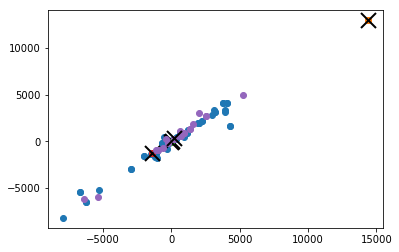

In [361]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(SigTest)

labels = kmeans.labels_
pom = (zip(labels, SigTest))
centroids = kmeans.cluster_centers_
print((centroids))

for i in range(5):
    d = np.array([]).reshape(0,2000)
    for j in range(len(pom)):
        if (pom[j][0] == i):
            d = np.r_[d, [pom[j][1].tolist()]]
    pyplot.plot(d[:,0],d[:,1],'o')        
    lines = pyplot.plot(centroids[i,0],centroids[i,1],'kx')
    pyplot.setp(lines,ms=15.0)
    pyplot.setp(lines,mew=2.0)
pyplot.show()

[[ 16.16304098  27.14929672  -2.03984972   0.10939951 -22.26125481
  -13.47354266  -7.22345482   1.71078596 -11.4237802  -10.99287366
    2.6782676   -4.08989845  -8.12838593]
 [ 14.97286536  24.44452795   0.32291252   6.1075657  -12.66044411
    7.2396079   13.95148011  14.73195442  -6.52469258 -15.27560804
   -9.82061462  -2.66951011  -7.23954885]
 [ 16.48975332  12.10378361 -13.91769881  31.22925307  -8.72705237
   16.66986959   2.37155166  21.1826213   -0.67613332 -12.41853851
    7.45987981  -9.95737567   5.78517249]
 [ 14.1085282   16.00046368 -11.64146602   2.76386948 -20.70942712
   15.74260094 -11.03632549 -14.24833248 -23.6829447  -22.33363742
   -0.57736613  -2.76858473  -2.5284832 ]
 [ 16.53883846  -6.96655375 -31.82665718  29.15256498 -28.45017134
    8.19394951   3.44738433  -8.82572997  16.86712617 -11.3316234
    3.88792117  -1.53873695  -1.9498361 ]]


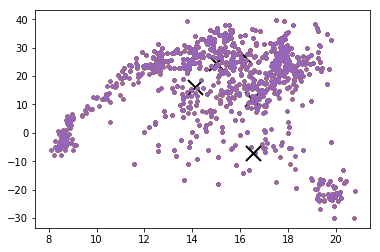

In [362]:
Means = fit_samples(mfcc_feat, 5)

print(Means)

for i in range(5):
    pyplot.plot(mfcc_feat[:,0],mfcc_feat[:,1],'.')
    lines = pyplot.plot(Means[i,0], Means[i,1],'kx')
    pyplot.setp(lines,ms=15.0)
    pyplot.setp(lines,mew=2.0)
pyplot.show()